In [45]:
import torch 
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt

In [46]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [47]:
t = transforms.Compose([
                        transforms.Resize(32),
                        transforms.CenterCrop(32),
                        transforms.ToTensor()
])
test_data = CIFAR10(root = './data', train = False, transform=t, download = True)
temp = test_data.class_to_idx
labelmap = {y:x for x,y in temp.items()}
print(labelmap)

Files already downloaded and verified
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [48]:
class NET(nn.Module):

  def __init__(self, out1, out2, n1, n2):
    super(NET,self).__init__()

    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=out1, kernel_size=(4,4), stride=(1,1), padding=2),
        nn.BatchNorm2d(out1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )

    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=(3,3), stride=(1,1), padding=1),
        nn.BatchNorm2d(out2),
        nn.ReLU(),
    )

    self.inshape = out2 * 16 * 16 

    self.fc1 = nn.Sequential(
        nn.Linear(in_features=self.inshape, out_features=n1),
        nn.BatchNorm1d(n1),
        nn.ReLU()
    )

    self.fc2 = nn.Sequential(
        nn.Linear(in_features=n1, out_features=n2),
        nn.BatchNorm1d(n2),
        nn.ReLU()
    )

    self.out = nn.Linear(in_features=n2, out_features=10)

  def forward(self,x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    #print(x.shape)
    x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))

    x = self.fc1(x)
    x = self.fc2(x)
    return self.out(x)

Accuracy on this set :  95.0 %


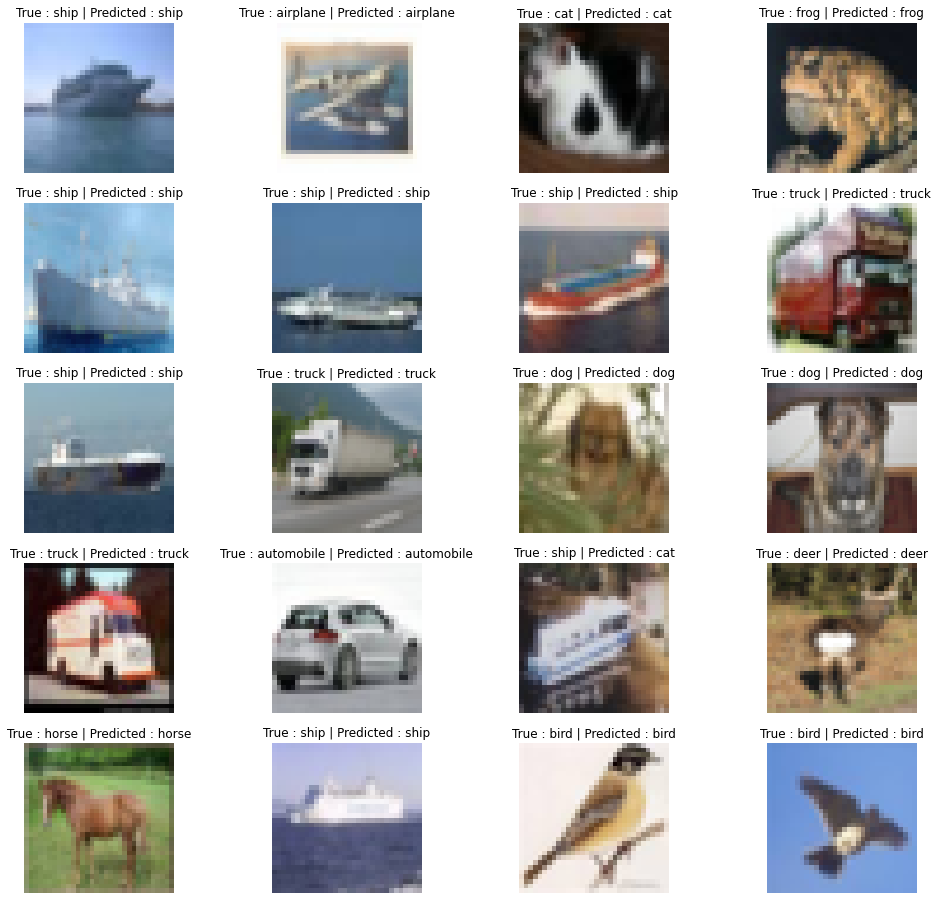

In [68]:
model = NET(32,64,512,256)
dict = torch.load('cifar_model_dict.pt', map_location=dev)
model.eval()
model.load_state_dict(dict)

random_images = torch.randint(low = 0,high = len(test_data), size = (20,))
fig,ax = plt.subplots(nrows = 5, ncols = 4, figsize = (17,16))
ax = ax.flatten()

counter = 0
correct, incorrect = 0,0
for i in random_images :
    img,label = test_data[i]
    img2 = transforms.ToPILImage()(img)
    
    pred = torch.argmax(model.forward(torch.unsqueeze(img,0)))
    label, pred = labelmap[label], labelmap[pred.item()]

    if label == pred :
        correct += 1 
    else :
        incorrect += 1

    title = f'True : {label} | Predicted : {pred}'
    ax[counter].set_title(title, size = 12)
    ax[counter].imshow(img2)
    ax[counter].axis(False)

    counter += 1

acc = (correct/(correct + incorrect)) * 100
print('Accuracy on this set : ', acc, '%')